# Deep learning - Practical n°2

## Student 1 : Emilie SALEM
## Student 2 : Hadrien SALEM 

# Preliminaries

In [580]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import copy

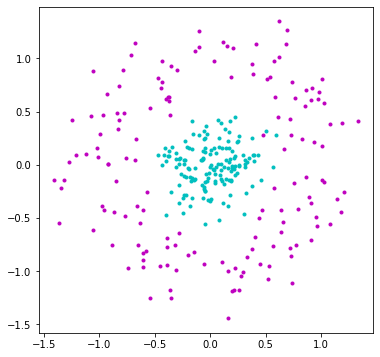

In [581]:
# Generation and display of the dataset

X,y = make_circles(n_samples = 300, noise=0.2, factor=0.1)
n,d = X.shape
plt.figure(1,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],".c")
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],".m")

In [582]:
# Utility functions

def sigmoid(x):
    res = 1 / (1 + np.exp(-x))
    return res

def onehot(y,i):
    """Creates a one-hot encoding of the i element of y"""
    return 1-np.array(list(bin(y[i]+1)[2:].zfill(2))).astype(int)

# Exercise 1: Network creation

In [583]:
# Definition of an input unit
class InputUnit:

    # Constructor
    def __init__(self,data):
        self.data = data # one column of matrix X
        self.n = data.shape[0] # dataset size
        self.k = 0 # layer number
        self.z = 0 # unit output

    def __str__(self):
        return f"Input unit in layer {self.k}, containing {self.n} examples."

    def plug(self, unit):
        unit.preceding.append(self)

    def forward(self,i):
        self.z = self.data[i]
        return self.z

In [584]:
# Creation of 2 input units, one for each column of X
input_unit_1 = InputUnit(X[:,0])
input_unit_2 = InputUnit(X[:,1])

In [585]:
# Definition of a neural unit
class NeuralUnit:
    
    # Constructor
    def __init__(self,k,u):
        self.u = u # unit number
        self.preceding = [] # list of preceding neurons
        # self.npr = 0 # length of list preceding
        self.following = [] # list of following neurons
        # self.nfo = 0 # length of list following
        self.k = k # layer number
        self.w = 0 # unit weights
        self.b = 0 # unit intercept
        self.z = 0 # unit output
        self.delta = np.zeros(np.shape(self.w))
        self.w_grad = np.zeros(np.shape(self.w))
        self.b_grad = 0

    def __str__(self):
        return f"Neural unit #{self.u} in layer {self.k} with {self.npr} preceding element(s) and {self.nfo} following element(s)."

    @property # custom getter for length of list preceding
    def npr(self):
        return len(self.preceding)

    @property # custom getter for length of list following
    def nfo(self):
        return len(self.following)

    def reset_params(self):
        self.w = np.random.randn(self.npr)
        self.b = np.random.randn()

    def plug(self, unit):
        unit.preceding.append(self)
        self.following.append(unit)

    def forward(self, i):
        z_in = np.zeros(self.npr)
        for index, unit in enumerate(self.preceding) :
            z_in[index] = unit.forward(i)
        self.z = sigmoid(self.w.dot(z_in) + self.b)
        return self.z

    def backprop(self, i, deltas):
        self.delta = np.zeros(np.shape(self.w))
        self.w_grad = np.zeros(np.shape(self.w))
        delta_u = deltas[self.u]
        for v in range(self.npr):
            self.delta[v] = (self.z*(1 - self.z)*self.w[v])*delta_u
            self.w_grad[v] = self.preceding[v].z*self.z*(1-self.z)*delta_u
        self.b_grad = self.z*(1-self.z)*delta_u

In [586]:
# Creation of the 3 neural units corresponding to this problem

# Layer 1
neural_unit_11 = NeuralUnit(1, 1)
neural_unit_12 = NeuralUnit(1, 2)

# Layer 2
neural_unit_21 = NeuralUnit(2, 1)

In [587]:
class Loss:

    # Constructor
    def __init__(self,y,k):
        self.preceding = [] # list of preceding neurons
        # self.npr = 0 # length of list preceding
        self.y = y # array of class labels of the training data
        self.k = k # layer index
        self.delta = np.zeros((1,))
            
    def __str__(self):
        return f"Loss unit in layer {self.k} with {self.npr} preceding element(s)."

    @property # custom getter for length of list preceding
    def npr(self):
        return len(self.preceding)

    def forward(self, i):
        z_in = self.preceding[0].forward(i)
        if self.y[i] == 0 : return -np.log(1-z_in)
        else : return -np.log(z_in)
            
    def backprop(self, i):
        z_in = self.preceding[0].z
        if self.y[i] == 0 : self.delta[0] = 1/(1-z_in)
        else : self.delta[0] = -1/z_in

In [588]:
# Creation of the loss unit
loss_unit = Loss(y, 3)

In [589]:
class MLP:
    # Constructor
    def __init__(self,X,y,archi):
        self.archi = archi
        self.X = X
        self.n = X.shape[0]
        self.y = y
        self.K = len(archi) # number of layers (including the input layer but without the loss layer)

        # Creating network
        net = []

        # Inputs
        n_inputs = archi[0]
        input_layer = []
        for i in range(n_inputs):
            input_layer.append(InputUnit(X[:,i]))
        net.append(input_layer)
            
        # Neural units
        for k in range(1, self.K) :
            layer = []
            n_units = archi[k]
            for j in range(n_units):
                layer.append(NeuralUnit(k,j))
            net.append(layer)

        # Loss
        loss_layer = [Loss(y, self.K)]
        net.append(loss_layer)

        # Plugging units together and resetting parameters
        for k in range(len(net) - 1):
            for unit in net[k] :
                if isinstance(unit, NeuralUnit) : unit.reset_params()
                for next_unit in net[k+1]:
                    unit.plug(next_unit)

        self.net = net

    def forward(self,i):
        return self.net[-1][0].forward(i)

    def backprop(self, i):
        # first iteration: loss layer
        self.net[-1][0].backprop(i)
        deltas = self.net[-1][0].delta

        for k in range(len(self.net)-2, 0, -1):
            deltas_new = np.zeros((self.net[k][0].npr,))
            for u in range(len(self.net[k])):
                self.net[k][u].backprop(i,deltas)
                deltas_new += self.net[k][u].delta
            deltas = deltas_new

    def update(self, eta):
        for k in range(1, len(self.net) - 1):
            for unit in self.net[k]:
                unit.w -= eta * unit.w_grad
                unit.b -= eta * unit.b_grad
    
    def train(self, epochs,eta):
        for epoch in range(epochs):
            for i in range(self.n):
                self.forward(i)
                self.backprop(i)
                self.update(eta)

In [590]:
# Instanciation of the network corresponding to our problem
archi = [2,2,1]
mlp = MLP(X,y,archi)

# Check unit connections and parameters initialization
for layer in mlp.net :
    for unit in layer :
        print(unit)

Input unit in layer 0, containing 300 examples.
Input unit in layer 0, containing 300 examples.
Neural unit #0 in layer 1 with 2 preceding element(s) and 1 following element(s).
Neural unit #1 in layer 1 with 2 preceding element(s) and 1 following element(s).
Neural unit #0 in layer 2 with 2 preceding element(s) and 1 following element(s).
Loss unit in layer 3 with 1 preceding element(s).


# Exercise 2: Forward pass

We programmed the `forward(self,i)` functions in all the above classes (different types of units and `MLP`).

In [591]:
# Checking that the forward methods are correctly programmed

index_0 = 0 # index of an element for which y = 0
loss_0 = mlp.forward(index_0)
output_neural_0 = mlp.net[2][0].z # output of the last neural unit of the network
print(f"For an example of class 0, the output of the last neural unit is {output_neural_0} and the loss is {loss_0}.")


index_1 = 45 # index of an element for which y = 1
loss_1 = mlp.forward(index_1)
output_neural_1 = mlp.net[2][0].z
print(f"For an example of class 1, the output of the last neural unit is {output_neural_1} and the loss is {loss_1}.")

For an example of class 0, the output of the last neural unit is 0.6293400144812036 and the loss is 0.9924701176816716.
For an example of class 1, the output of the last neural unit is 0.5182646911910189 and the loss is 0.730360467619225.


These tests allow us to check that the loss is higher when the prediction of the network is wrong : the forward functions seem to be programmed properly.

# Exercise 3: Backprop

We added `backprop` methods to the `Loss` and `NeuralUnit` classes.

In [592]:
# Testing the computed gradients
i = 0
archi = [d,10,1]
mlp = MLP(X,y,archi)
mlp.forward(i)
mlp.backprop(i)
epsi=1e-3
mlp2 = copy.deepcopy(mlp)
mlp2.net[1][0].w[0] = mlp.net[1][0].w[0] + epsi
print("numerical derivative is:",(mlp2.forward(i) - mlp.forward(i))/epsi)
print("computed derivative is:",mlp.net[1][0].w_grad[0])

numerical derivative is: -0.002565106453800148
computed derivative is: -0.002564749334484727


The numerical derivatives are very close to the computed ones: it seems that our implementation is correct.

# Exercise 4 : SGD training of the network

We implemented an `update` and a `train` method in the `MLP` class.

In [596]:
# Training the mlp
mlp.train(50,0.01)